In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from neuralprophet import NeuralProphet

import warnings
warnings.filterwarnings("ignore")

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

<AxesSubplot:>

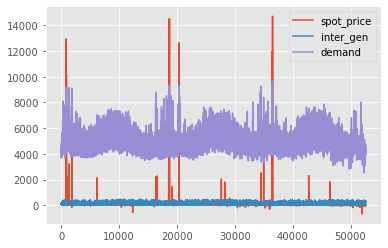

In [2]:
train = pd.read_csv("../../data/vic_train.csv")
valid = pd.read_csv("../../data/vic_cv.csv")
train['time'] = pd.to_datetime(train['time'])
valid['time'] = pd.to_datetime(valid['time'])

cols = list(train)[1:4]
train[cols].plot.line()

In [3]:
df = train
df = df.append(valid)
df_test = df.drop(['spot_price', 'period'], axis=1)
df_test = df_test.reset_index(drop=True)
df_test.columns = ['ds', 'inter_gen', 'demand']

In [4]:
df_train = train[list(train)[0:4]]
df_train.columns = ['ds', 'y', 'inter_gen', 'demand']

In [59]:
m = Prophet(growth="linear", seasonality_mode="multiplicative", changepoint_prior_scale=30, 
                  seasonality_prior_scale=35,
                  holidays_prior_scale=20,
                  daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=False,
                  ).add_seasonality(name='monthly',
                  period=30.5,
                  fourier_order=55
                  ).add_seasonality(name='daily',
                  period = 1,
                  fourier_order=15
                  ).add_seasonality(name="weekly",
                  period = 7,
                  fourier_order=20
                  ).add_seasonality(name ="yearly",
                  period = 365.25,
                  fourier_order=20
                  ).add_seasonality(name ="quarterly",
                  period = 365.25/4,
                  fourier_order=5,
                  prior_scale = 15)
m.add_regressor('inter_gen')
m.add_regressor('demand')
model = m.fit(df_train)

In [5]:
m = Prophet(interval_width=0.95, daily_seasonality=True, changepoint_prior_scale=30, 
            seasonality_prior_scale=35,
            holidays_prior_scale=40)
m.add_country_holidays(country_name='AU')
m.add_regressor('inter_gen')
m.add_regressor('demand')
model = m.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
forecast = m.predict(df_test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Australia Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,84.16,-426.54,683.19,84.16,84.16,0.00,0.00,0.00,0.00,...,13.40,13.40,13.40,-35.72,-35.72,-35.72,0.00,0.00,0.00,151.87
1,2018-01-01 00:30:00,84.13,-446.41,749.90,84.13,84.13,0.00,0.00,0.00,0.00,...,11.88,11.88,11.88,-35.70,-35.70,-35.70,0.00,0.00,0.00,134.31
2,2018-01-01 01:00:00,84.11,-419.51,696.23,84.11,84.11,0.00,0.00,0.00,0.00,...,10.35,10.35,10.35,-35.68,-35.68,-35.68,0.00,0.00,0.00,122.19
3,2018-01-01 01:30:00,84.08,-439.10,711.36,84.08,84.08,0.00,0.00,0.00,0.00,...,8.83,8.83,8.83,-35.66,-35.66,-35.66,0.00,0.00,0.00,113.34
4,2018-01-01 02:00:00,84.05,-427.13,675.36,84.05,84.05,0.00,0.00,0.00,0.00,...,7.32,7.32,7.32,-35.64,-35.64,-35.64,0.00,0.00,0.00,101.40


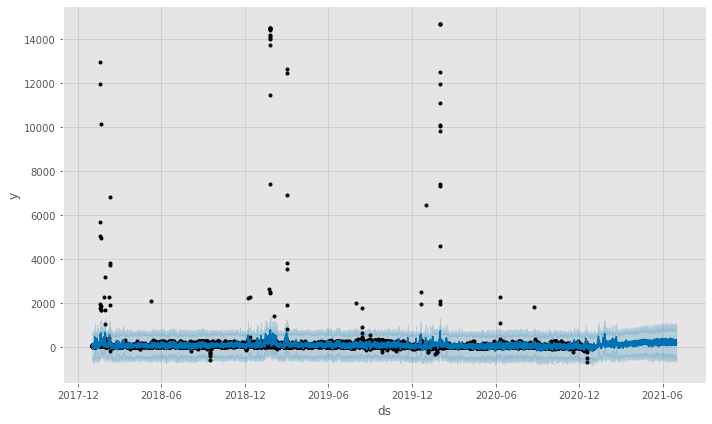

In [8]:
plot1 = m.plot(forecast)

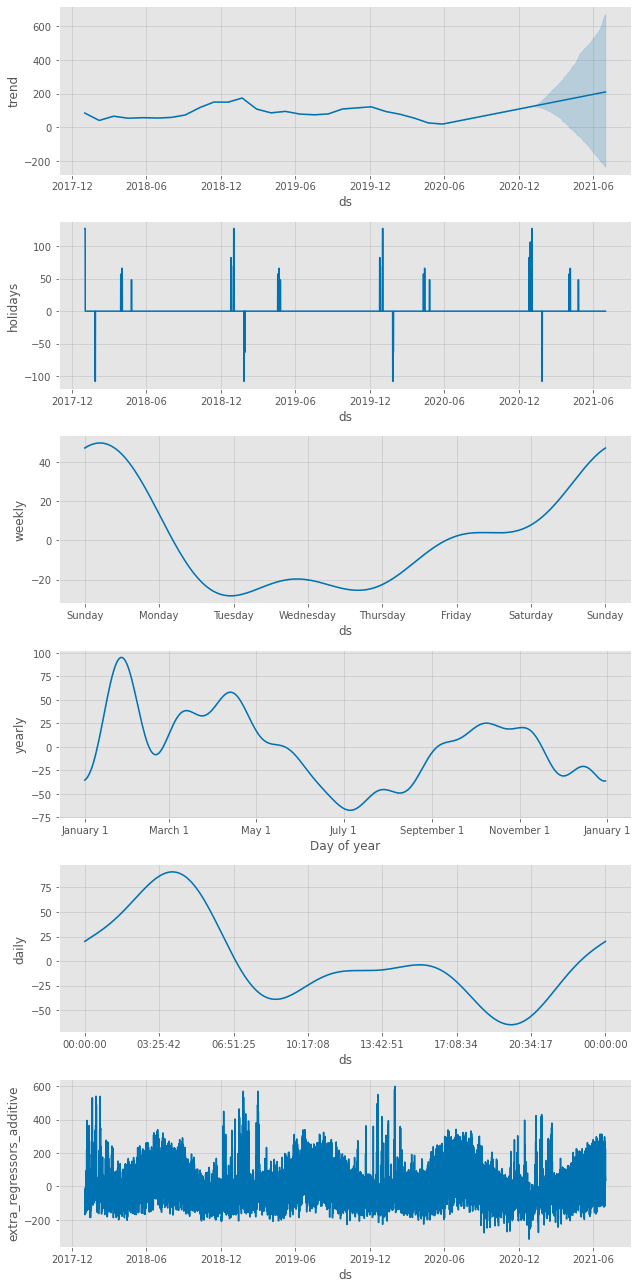

In [9]:
plt2 = m.plot_components(forecast)

In [10]:
m.train_holiday_names

0              New Year's Day
1               Australia Day
2                 Good Friday
3               Easter Monday
4                   Anzac Day
5               Christmas Day
6                  Boxing Day
7    Australia Day (Observed)
8       Boxing Day (Observed)
dtype: object

In [11]:
eval_df = forecast[['ds', 'yhat']]
eval_df = pd.merge(eval_df, df, left_on='ds', right_on='time')
eval_df.set_axis(eval_df['ds'], inplace=True)

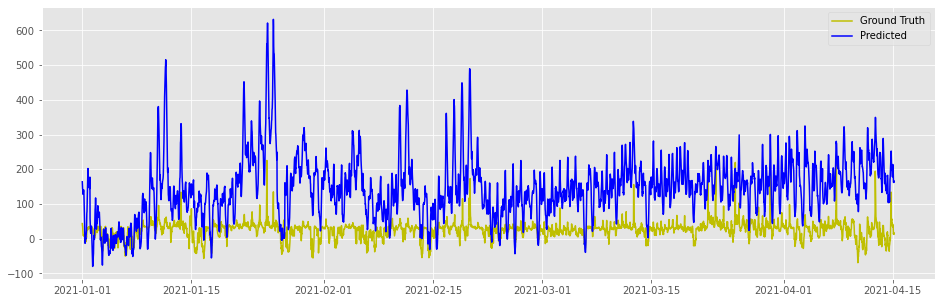

In [12]:
plt.figure(figsize=(16, 5))
eval_df = eval_df[eval_df['time'] >= '2021-01-01 00:00:00']
plt.plot(eval_df[0:5000]['spot_price'], color='y', label='Ground Truth')
plt.plot(eval_df[0:5000]['yhat'], color='b', label='Predicted')
plt.legend()
plt.show()

In [13]:
mse = mean_squared_error(eval_df.spot_price, eval_df.yhat)
print("Prophet Model RMSE:", math.sqrt(mse))

Prophet Model RMSE: 197.1722388638361
